In [1]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModel, AutoConfig, AdamW, get_linear_schedule_with_warmup
from datasets import Dataset, load_metric
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

/Users/watanabeshingo/sentiment/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# pandas.DataFrameとして読み込む
df_wrime = pd.read_table('wrime-ver1.tsv')

In [3]:
# Plutchikの8つの基本感情
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']
emotion_names_jp = ['喜び', '悲しみ', '期待', '驚き', '怒り', '恐れ', '嫌悪', '信頼']  # 日本語版
num_labels = len(emotion_names)

# readers_emotion_intensities 列を生成する
# "Avg. Readers_*" の値をlist化したもの
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)

# 感情強度が低いサンプルは除外する
# (readers_emotion_intensities の max が２以上のサンプルのみを対象とする)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]
     

In [4]:
# train / test に分割する
df_groups = df_wrime_target.groupby('Train/Dev/Test')
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))
print('test :', len(df_test))

train : 17104
test : 1133


In [5]:
# 使用するモデルを指定して、Tokenizerを読み込む
checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [6]:
# 前処理関数: tokenize_function
# 感情強度の正規化（総和=1）も同時に実施する
def tokenize_function(batch):
    tokenized_batch = tokenizer(batch['Sentence'], truncation=True, padding='max_length')
    tokenized_batch['labels'] = [x / np.sum(x) for x in batch['readers_emotion_intensities']]  # 総和=1に正規化
    return tokenized_batch

# Transformers用のデータセット形式に変換
# pandas.DataFrame -> datasets.Dataset
target_columns = ['Sentence', 'readers_emotion_intensities']
train_dataset = Dataset.from_pandas(df_train[target_columns])
test_dataset = Dataset.from_pandas(df_test[target_columns])

# 前処理（tokenize_function） を適用
train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
test_tokenized_dataset = test_dataset.map(tokenize_function, batched=True)

Parameter 'function'=<function tokenize_function at 0x295446980> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Map: 100%|██████████| 1133/1133 [00:00<00:00, 6763.99 examples/s]


In [7]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# 評価指標を定義
# https://huggingface.co/docs/transformers/training
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    label_ids = np.argmax(labels, axis=-1)
    return metric.compute(predictions=predictions, references=label_ids)


/var/folders/8n/5_hjqypx3xngd_rdl100yp2r0000gn/T/ipykernel_83300/1992756082.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/Users/watanabeshingo/sentiment/.venv/lib/python3.11/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [9]:
# AdamWオプティマイザの定義
optimizer = AdamW(model.parameters(), lr=2e-5)  # lrは学習率,これがデフォルト

/Users/watanabeshingo/sentiment/.venv/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
def tokenize_batch(batch):
    return tokenizer(batch['Sentence'], truncation=True, padding=True)

In [11]:
# (1)
#データセット内の各サンプルのSentenceを同じ長さに調整する
# パディングを行うか、あるいはトリミングを行う
max_length = 512  # 調整後の最大長さ

# Sentenceを指定した長さにトリミングする関数
def trim_sentence(sample, tokenizer, max_length):
    # Sentenceをトークン化
    tokens = tokenizer(
        sample['Sentence'],
        max_length=max_length,
        truncation=True,
        padding='max_length'  # パディングもmax_lengthに合わせる
    )

    # トリミング後のトークンを元のフィーチャに反映
    sample['input_ids'] = tokens['input_ids'][:max_length]
    sample['attention_mask'] = tokens['attention_mask'][:max_length]

    return sample

# トリミングを適用
trimmed_train_tokenized_dataset = [trim_sentence(sample, tokenizer, max_length) for sample in train_tokenized_dataset]
trimmed_test_tokenized_dataset = [trim_sentence(sample, tokenizer, max_length) for sample in test_tokenized_dataset]


In [12]:
# トレーニング時の設定
training_args = TrainingArguments(
    output_dir="test_trainer",
    per_device_train_batch_size=7,
    num_train_epochs=0.9,
    evaluation_strategy="steps",
    eval_steps=200,
    lr_scheduler_type="linear",  # スケジューラのタイプを指定
)

# 学習率のスケジューラの設定
num_training_steps = len(train_tokenized_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs
warmup_steps = int(0.1 * num_training_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=num_training_steps
)


In [25]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels", None)

        if labels is None:
            if "labels" not in inputs or inputs["labels"] is None:
                raise ValueError("Labels are missing or None in the inputs during training.")
            else:
                labels = inputs["labels"]

        # モデルのフォワードパス
        outputs = model(**inputs)
        # logitsから損失を計算
        loss = nn.CrossEntropyLoss()(outputs.logits, labels)

        if return_outputs:
            return loss, outputs
        else:
            return loss

In [26]:
custom_trainer = CustomTrainer(
    model=model,                        # トレーニングするモデル
    args=training_args,                  # トレーニングの設定
    train_dataset=trimmed_train_tokenized_dataset,  # トレーニングデータセット
    eval_dataset=trimmed_test_tokenized_dataset,    # 評価データセット
    compute_metrics=compute_metrics,     # メトリクスの計算関数
    # data_collator=pad_collate,  # パディングを行うデータコレーターを指定
    optimizers=(optimizer, scheduler)    # カスタムTrainerにはoptimizerとschedulerをタプルで渡す
)

# 訓練を実行
custom_trainer.train()

  9%|▉         | 200/2200 [05:07<50:46,  1.52s/it]














































































































































                                     

                                                  
  9%|▉         | 200/2200 [06:30<50:46,  1.52s/it]


{'eval_loss': 1.4976178407669067, 'eval_accuracy': 0.4854368932038835, 'eval_runtime': 83.3776, 'eval_samples_per_second': 13.589, 'eval_steps_per_second': 1.703, 'epoch': 0.08}


 18%|█▊        | 400/2200 [12:14<52:19,  1.74s/it]   














































































































































                                     

                                                  
 18%|█▊        | 400/2200 [13:43<52:19,  1.74s/it]


{'eval_loss': 1.2440986633300781, 'eval_accuracy': 0.6301853486319505, 'eval_runtime': 88.7915, 'eval_samples_per_second': 12.76, 'eval_steps_per_second': 1.599, 'epoch': 0.16}


 23%|██▎       | 500/2200 [16:43<50:09,  1.77s/it]

{'loss': 1.6379, 'learning_rate': 1.716118603828863e-05, 'epoch': 0.2}


 27%|██▋       | 600/2200 [19:44<47:41,  1.79s/it]  














































































































































                                     

                                                  
 27%|██▋       | 600/2200 [21:13<47:41,  1.79s/it]


{'eval_loss': 1.161460041999817, 'eval_accuracy': 0.6681376875551632, 'eval_runtime': 89.2013, 'eval_samples_per_second': 12.702, 'eval_steps_per_second': 1.592, 'epoch': 0.25}


 36%|███▋      | 800/2200 [27:32<43:07,  1.85s/it]   














































































































































                                     

                                                  
 36%|███▋      | 800/2200 [29:11<43:07,  1.85s/it]


{'eval_loss': 1.1474782228469849, 'eval_accuracy': 0.6893203883495146, 'eval_runtime': 99.7438, 'eval_samples_per_second': 11.359, 'eval_steps_per_second': 1.424, 'epoch': 0.33}


 45%|████▌     | 1000/2200 [36:05<40:05,  2.00s/it]

{'loss': 1.3413, 'learning_rate': 1.2109915643784413e-05, 'epoch': 0.41}

















































































































































                                     

                                                   
 45%|████▌     | 1000/2200 [37:49<40:05,  2.00s/it]


{'eval_loss': 1.0891634225845337, 'eval_accuracy': 0.7166813768755517, 'eval_runtime': 103.9824, 'eval_samples_per_second': 10.896, 'eval_steps_per_second': 1.366, 'epoch': 0.41}


 55%|█████▍    | 1200/2200 [44:43<33:00,  1.98s/it]   














































































































































                                     

                                                   
 55%|█████▍    | 1200/2200 [46:26<33:00,  1.98s/it]


{'eval_loss': 1.0697382688522339, 'eval_accuracy': 0.7113857016769638, 'eval_runtime': 102.9712, 'eval_samples_per_second': 11.003, 'eval_steps_per_second': 1.379, 'epoch': 0.49}


 64%|██████▎   | 1400/2200 [53:08<30:19,  2.27s/it]  














































































































































                                     

                                                   
 64%|██████▎   | 1400/2200 [54:53<30:19,  2.27s/it]


{'eval_loss': 1.0500515699386597, 'eval_accuracy': 0.7237422771403353, 'eval_runtime': 104.7126, 'eval_samples_per_second': 10.82, 'eval_steps_per_second': 1.356, 'epoch': 0.57}


 68%|██████▊   | 1500/2200 [58:20<24:17,  2.08s/it]

{'loss': 1.2605, 'learning_rate': 7.058645249280196e-06, 'epoch': 0.61}


 73%|███████▎  | 1600/2200 [1:01:52<23:53,  2.39s/it]














































































































































                                     

                                                     
 73%|███████▎  | 1600/2200 [1:03:40<23:53,  2.39s/it]


{'eval_loss': 1.0410785675048828, 'eval_accuracy': 0.7246248896734334, 'eval_runtime': 108.4615, 'eval_samples_per_second': 10.446, 'eval_steps_per_second': 1.309, 'epoch': 0.65}


 82%|████████▏ | 1800/2200 [1:10:19<11:59,  1.80s/it]  














































































































































                                       

                                                     
 82%|████████▏ | 1800/2200 [1:11:52<11:59,  1.80s/it]


{'eval_loss': 1.0264426469802856, 'eval_accuracy': 0.7387466902030009, 'eval_runtime': 93.0429, 'eval_samples_per_second': 12.177, 'eval_steps_per_second': 1.526, 'epoch': 0.74}


 91%|█████████ | 2000/2200 [1:18:04<06:06,  1.83s/it]

{'loss': 1.2012, 'learning_rate': 2.007374854775979e-06, 'epoch': 0.82}

















































































































































                                       

                                                     
 91%|█████████ | 2000/2200 [1:19:41<06:06,  1.83s/it]


{'eval_loss': 1.0272704362869263, 'eval_accuracy': 0.736098852603707, 'eval_runtime': 96.4645, 'eval_samples_per_second': 11.745, 'eval_steps_per_second': 1.472, 'epoch': 0.82}


100%|██████████| 2200/2200 [1:26:11<00:00,  2.13s/it]  














































































































































                                       

                                                     
100%|██████████| 2200/2200 [1:27:49<00:00,  2.13s/it]

100%|██████████| 2200/2200 [1:27:49<00:00,  2.40s/it]

{'eval_loss': 1.017547369003296, 'eval_accuracy': 0.7396293027360988, 'eval_runtime': 98.432, 'eval_samples_per_second': 11.51, 'eval_steps_per_second': 1.443, 'epoch': 0.9}
{'train_runtime': 5269.8222, 'train_samples_per_second': 2.921, 'train_steps_per_second': 0.417, 'train_loss': 1.3499453943425959, 'epoch': 0.9}


TrainOutput(global_step=2200, training_loss=1.3499453943425959, metrics={'train_runtime': 5269.8222, 'train_samples_per_second': 2.921, 'train_steps_per_second': 0.417, 'train_loss': 1.3499453943425959, 'epoch': 0.9})

In [28]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']


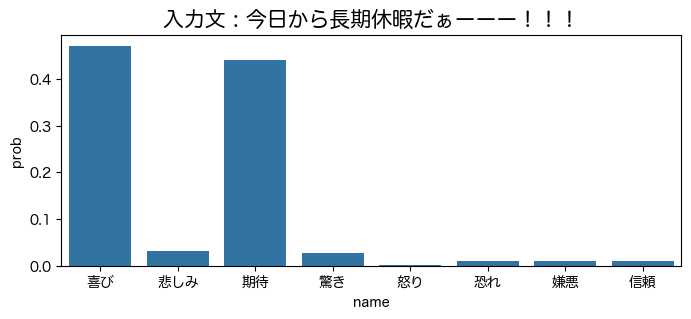

In [29]:
# https://www.delftstack.com/ja/howto/numpy/numpy-softmax/
def np_softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

def analyze_emotion(text, show_fig=False, ret_prob=False):
    # 推論モードを有効化
    model.eval()

    # 入力データ変換 + 推論
    tokens = tokenizer(text, truncation=True, return_tensors="pt")
    tokens.to(model.device)
    preds = model(**tokens)
    prob = np_softmax(preds.logits.cpu().detach().numpy()[0])
    out_dict = {n: p for n, p in zip(emotion_names_jp, prob)}

    # 棒グラフを描画
    if show_fig:
        plt.figure(figsize=(8, 3))
        # 縦軸を固定する
        plt.ylim(0, 1)
        df = pd.DataFrame(out_dict.items(), columns=['name', 'prob'])
        sns.barplot(x='name', y='prob', data=df)
        plt.title('入力文 : ' + text, fontsize=15)

    if ret_prob:
        return out_dict

# 動作確認
analyze_emotion('今日から長期休暇だぁーーー！！！', show_fig=True)

In [30]:
# modelの保存
model.save_pretrained('./model/wrime_model.bin')

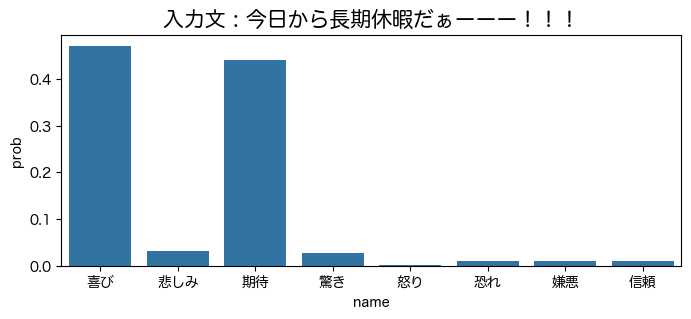

In [31]:
# modelの読み込み
model = AutoModelForSequenceClassification.from_pretrained('./model/wrime_model.bin', num_labels=num_labels)

# 動作確認
analyze_emotion('今日から長期休暇だぁーーー！！！', show_fig=True)
